In [344]:
from bs4 import BeautifulSoup as bs
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import time
import requests
import random
import aiohttp
import seaborn as sns
import re

In [345]:
async def getJSONData(full_url):
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(full_url) as r:
                if r.status == 200:
                    js = await r.json()
                    return js
    except:
        return None


In [346]:
def getTrackData(player_id):
    url = 'https://mkwlounge.gg/ladder/player.php?player_id={}&ladder_id=3'.format(player_id)
    # print(url)
    playerpage = requests.get(url, timeout=3)
    playersoup = bs(playerpage.content)
    playertables = playersoup.find_all('table')
    dfs = pd.read_html(str(playertables))[3]
    return dfs

In [347]:
def formatTrackData(df, index):
    df.drop(['Std Dev Time', 'Average Points', 'Fastest Time', 'Slowest Time'], axis=1, inplace=True)
    melted = df.pivot(index = 'Engine', columns='Track')
    melted = melted.drop('Mirror', axis=0, errors='ignore')
    melted = melted.drop('100cc', axis=0, errors='ignore')
    melted = melted.rename(index={'150cc': index})
    return melted

In [348]:
upperDict = {'Average Placement':'AP',
             'Average Time': 'AT',
             'Races': 'R',
             'player_id':'player_id'}
def renameCols(df):
    df.rename(columns=lambda x: upperDict[x], level=0, inplace=True)
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df.drop(['AT -','AP -', 'R -'], axis=1, inplace=True)
    df.rename(columns=lambda c: c.replace(' (Nintendo)',''), inplace=True)
    df.index.name = None
    return df

In [349]:
async def getPlayerData():
    metadata = await getJSONData('https://www.mkwlounge.gg/api/ladderplayer.php?ladder_type=rt&all=1')
    playerdata = pd.DataFrame(metadata['results'])
    playerdata = playerdata[['player_id','player_name','current_mmr','current_lr','current_class','win_percentage','win10_percentage','average_score','average10_score','total_events']]
    playerdata = playerdata.loc[playerdata["total_events"]!= 0]
    playerdata = playerdata.loc[playerdata["current_mmr"] >= 0]
    return playerdata

In [350]:
def getTime(time):
    min, sec = time.split(':')
    t = (int(min) * 60) + float(sec) 
    
    return t

In [351]:
def typeColumns(combodata):
    APcols = combodata.columns[10:42]
    ATcols = combodata.columns[42:74]
    Rcols = combodata.columns[74:106]
    for r in Rcols:
        combodata[r] = combodata[r].replace(np.nan, 0)
        combodata[r] = combodata[r].astype(int)
    for p in APcols:
        combodata[p] = combodata[p].replace(np.nan, '13th')
        combodata[p] = combodata[p].apply(lambda x: re.sub("[^0-9]", "", x)) 
        combodata[p] = combodata[p].astype(int)
    for T in ATcols:
        combodata[T] = combodata[T].replace(np.nan, np.inf)
        combodata[T] = combodata[T].apply(lambda x: getTime(x) if x != np.inf else x)
        combodata[T] = combodata[T].astype(float)
    return combodata

In [352]:
playerdata = await getPlayerData()
playerdata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events
0,260,Az,17187,15882,Class X,0.963636,1.000000,99.1273,97.20,55
1,290,barney,15282,15594,Class X,0.795918,0.800000,91.2125,92.50,99
2,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.75,127
3,1614,Kasperinos,14167,14914,Class X,0.750000,0.400000,90.3158,79.50,97
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.90,92


In [353]:


dfs = []
i =0
for index, row in playerdata.iterrows():
    trackdata = getTrackData(row['player_id'])
    formatData = formatTrackData(trackdata, index)
    formatData['player_id'] = row['player_id']
    dfs.append(formatData)
    # if i %100 == 0:
    #     print('working: ' + str(i))
    # i = i + 1

trackdata = pd.DataFrame().append(dfs)
trackdata = renameCols(trackdata)
trackdata.head()

/Users/fordjackson/opt/anaconda3/envs/appML/lib/python3.9/site-packages/bs4/__init__.py:611: RuntimeWarning: coroutine 'getJSONData' was never awaited
  o.setup(parent, previous_element, next_element, previous_sibling, next_sibling)


,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,AP GBA Shy Guy Beach,AP GCN DK Mountain,AP GCN Mario Circuit,AP GCN Peach Beach,AP GCN Waluigi Stadium,...,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine,player_id
0,5th,5th,5th,4th,5th,3rd,5th,4th,5th,5th,...,47.0,59.0,25.0,17.0,98.0,129.0,16.0,39.0,14.0,260
1,6th,5th,6th,4th,5th,8th,6th,5th,6th,5th,...,63.0,69.0,22.0,21.0,89.0,125.0,19.0,42.0,35.0,290
2,6th,5th,5th,5th,5th,5th,5th,6th,6th,6th,...,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0,1207
3,5th,5th,5th,5th,5th,5th,5th,7th,5th,5th,...,57.0,45.0,27.0,20.0,104.0,108.0,8.0,36.0,22.0,1614
4,6th,5th,5th,6th,5th,3rd,4th,6th,6th,5th,...,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0,1043


In [366]:
combodata = pd.merge(playerdata,trackdata, left_on='player_id', right_on='player_id')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17187,15882,Class X,0.963636,1.000000,99.1273,97.20,55,...,61.0,47.0,59.0,25.0,17.0,98.0,129.0,16.0,39.0,14.0
1,290,barney,15282,15594,Class X,0.795918,0.800000,91.2125,92.50,99,...,97.0,63.0,69.0,22.0,21.0,89.0,125.0,19.0,42.0,35.0
2,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.75,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
3,1614,Kasperinos,14167,14914,Class X,0.750000,0.400000,90.3158,79.50,97,...,76.0,57.0,45.0,27.0,20.0,104.0,108.0,8.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.90,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


In [28]:
combodata.to_csv('datasets/loungedata.csv', index=False)

## If data has already been sourced

In [152]:
combodata = pd.read_csv('datasets/loungedata.csv')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17155,15757,Class X,0.962963,1.000000,99.0370,96.1000,54,...,61,46,59,24,17,97,128,16,39,14
1,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.7500,127,...,161,146,121,61,24,217,304,36,79,54
2,290,barney,14495,14979,Class X,0.784946,0.600000,91.0257,90.7000,94,...,94,61,67,22,21,87,122,18,42,34
3,1614,Kasperinos,13902,14817,Class X,0.758242,0.400000,90.2771,76.9286,92,...,73,55,43,26,19,102,104,7,36,22
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.9000,92,...,70,58,54,20,15,62,104,13,31,22


In [355]:
combodata['current_class'] = combodata['current_class'].astype('category')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17187,15882,Class X,0.963636,1.000000,99.1273,97.20,55,...,61.0,47.0,59.0,25.0,17.0,98.0,129.0,16.0,39.0,14.0
1,290,barney,15282,15594,Class X,0.795918,0.800000,91.2125,92.50,99,...,97.0,63.0,69.0,22.0,21.0,89.0,125.0,19.0,42.0,35.0
2,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.75,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
3,1614,Kasperinos,14167,14914,Class X,0.750000,0.400000,90.3158,79.50,97,...,76.0,57.0,45.0,27.0,20.0,104.0,108.0,8.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.90,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


## Data plotting and EDA

In [136]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='current_mmr', ylabel='Count'>

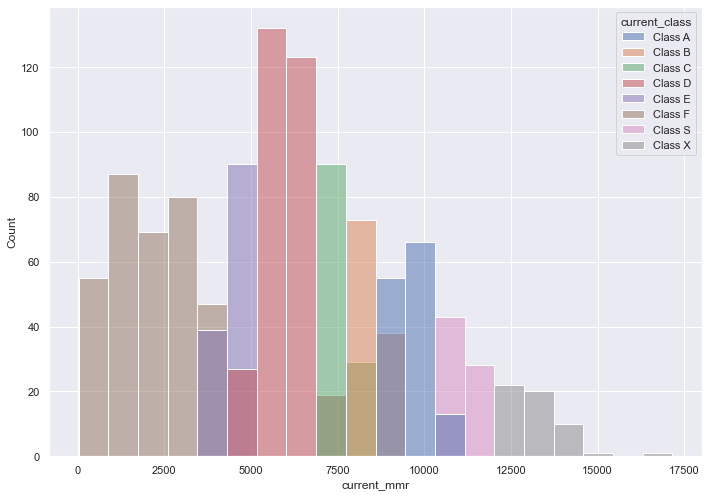

In [137]:
sns.histplot(data = combodata, x='current_mmr', hue = 'current_class', bins=20)

In [138]:
combodata[APcols].describe()

,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,AP GBA Shy Guy Beach,AP GCN DK Mountain,AP GCN Mario Circuit,AP GCN Peach Beach,AP GCN Waluigi Stadium,...,AP Wii Koopa Cape,AP Wii Luigi Circuit,AP Wii Maple Treeway,AP Wii Mario Circuit,AP Wii Moo Moo Meadows,AP Wii Moonview Highway,AP Wii Mushroom Gorge,AP Wii Rainbow Road,AP Wii Toad's Factory,AP Wii Wario's Gold Mine
count,1185,855,1143,974,1204,870,1129,955,1001,1132,...,1130,1095,1131,971,1030,1157,1199,1043,1179,1041
unique,12,12,12,12,11,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
top,6th,6th,6th,6th,6th,6th,6th,6th,6th,6th,...,6th,7th,6th,6th,6th,6th,6th,6th,6th,6th
freq,449,173,415,249,458,195,333,224,298,380,...,382,329,343,247,260,370,438,250,433,292


In [139]:
combodata.loc[combodata['player_id'] == 4088]

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
423,4088,fordj262,4226,4116,Class E,0.75,0.75,85.0,85.0,4,...,1.0,1.0,1.0,NaN,1.0,NaN,2.0,1.0,2.0,NaN


In [153]:
combodata.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 106 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    player_id                   1257 non-null   int64  
 1    player_name                 1257 non-null   object 
 2    current_mmr                 1257 non-null   int64  
 3    current_lr                  1257 non-null   int64  
 4    current_class               1257 non-null   object 
 5    win_percentage              1257 non-null   float64
 6    win10_percentage            1257 non-null   float64
 7    average_score               1257 non-null   float64
 8    average10_score             1257 non-null   float64
 9    total_events                1257 non-null   int64  
 10   AP DS Delfino Square        1257 non-null   int64  
 11   AP DS Desert Hills          1257 non-null   int64  
 12   AP DS Peach Gardens         1257 non-null   int64  
 13   AP DS Yoshi Fall

In [141]:
print(combodata[ATcols[0]].iloc[0])

2:24.794


In [142]:
combodata[ATcols].describe()

,AT DS Delfino Square,AT DS Desert Hills,AT DS Peach Gardens,AT DS Yoshi Falls,AT GBA Bowser Castle 3,AT GBA Shy Guy Beach,AT GCN DK Mountain,AT GCN Mario Circuit,AT GCN Peach Beach,AT GCN Waluigi Stadium,...,AT Wii Koopa Cape,AT Wii Luigi Circuit,AT Wii Maple Treeway,AT Wii Mario Circuit,AT Wii Moo Moo Meadows,AT Wii Moonview Highway,AT Wii Mushroom Gorge,AT Wii Rainbow Road,AT Wii Toad's Factory,AT Wii Wario's Gold Mine
count,1185,855,1143,974,1204,870,1129,955,1001,1132,...,1130,1095,1131,971,1030,1157,1199,1043,1179,1041
unique,1110,817,1057,900,1145,829,1077,898,928,1069,...,1066,1011,1086,911,952,1093,1111,1002,1106,996
top,2:27.107,1:53.077,2:23.018,1:14.715,2:40.041,1:42.329,2:31.040,1:54.805,1:28.743,2:14.177,...,2:42.595,1:25.267,2:39.985,1:36.677,1:33.595,2:04.416,2:04.497,2:53.436,2:12.676,2:10.641
freq,3,2,4,3,3,2,3,3,3,2,...,3,4,3,2,3,3,3,3,3,3


## Filling Na valuse

In [357]:
APcols = combodata.columns[10:42]
ATcols = combodata.columns[42:74]
Rcols = combodata.columns[74:106]

In [377]:
for r in Rcols:
    combodata[r] = combodata[r].replace(np.nan, 0)
    combodata[r] = combodata[r].astype(int)

In [378]:
for p in APcols:
    combodata[p] = combodata[p].replace(np.nan, '13th')
    combodata[p] = combodata[p].apply(lambda x: re.sub("[^0-9]", "", x)) 
    combodata[p] = combodata[p].astype(int)

In [380]:
for T in ATcols:
    avg = pd.DataFrame(combodata[['current_class',T]]])
    avg.groupby('current_class').agg({T: lambda x: x.mean(skipna=True)})
    combodata[T] = combodata[T].replace(np.nan, np.inf)
    combodata[T] = combodata[T].apply(lambda x: getTime(x) if x != np.inf else x)
    combodata[T] = combodata[T].astype(float)

In [394]:
for T in ATcols:
    
    combodata[T] = combodata[T].apply(lambda x: np.nan if x == np.inf else x)
    
    

In [430]:
avg = pd.DataFrame(combodata[['current_class',ATcols[0]]])
groups = avg.groupby('current_class').agg({ATcols[0]: lambda x: x.mean(skipna=True)})
groups['current_class'] = groups.index
groups.loc[groups['current_class'] == 'Class A'][ATcols[0]]


current_class
Class A    146.366654
Name: AT DS Delfino Square, dtype: float64

<AxesSubplot:xlabel='AP DS Delfino Square', ylabel='Count'>

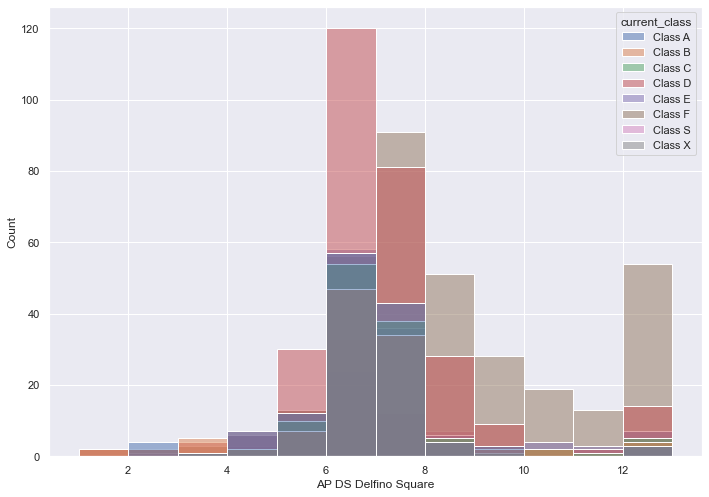

In [150]:
sns.histplot(data = combodata, x=APcols[0], hue='current_class', bins=12)

    

In [57]:
re.sub("[^0-9]", "", "1st")

'1'

In [155]:
combodata[ATcols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AT DS Delfino Square        1257 non-null   float64
 1   AT DS Desert Hills          1257 non-null   float64
 2   AT DS Peach Gardens         1257 non-null   float64
 3   AT DS Yoshi Falls           1257 non-null   float64
 4   AT GBA Bowser Castle 3      1257 non-null   float64
 5   AT GBA Shy Guy Beach        1257 non-null   float64
 6   AT GCN DK Mountain          1257 non-null   float64
 7   AT GCN Mario Circuit        1257 non-null   float64
 8   AT GCN Peach Beach          1257 non-null   float64
 9   AT GCN Waluigi Stadium      1257 non-null   float64
 10  AT N64 Bowser's Castle      1257 non-null   float64
 11  AT N64 DK's Jungle Parkway  1257 non-null   float64
 12  AT N64 Mario Raceway        1257 non-null   float64
 13  AT N64 Sherbet Land         1257 

In [151]:
combodata.to_csv('datasets/loungedata.csv', index=False)

In [122]:
print(type(np.inf))

<class 'float'>


In [159]:
combodata = pd.read_csv('datasets/loungedata.csv')
combodata.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 106 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    player_id                   1257 non-null   int64  
 1    player_name                 1257 non-null   object 
 2    current_mmr                 1257 non-null   int64  
 3    current_lr                  1257 non-null   int64  
 4    current_class               1257 non-null   object 
 5    win_percentage              1257 non-null   float64
 6    win10_percentage            1257 non-null   float64
 7    average_score               1257 non-null   float64
 8    average10_score             1257 non-null   float64
 9    total_events                1257 non-null   int64  
 10   AP DS Delfino Square        1257 non-null   int64  
 11   AP DS Desert Hills          1257 non-null   int64  
 12   AP DS Peach Gardens         1257 non-null   int64  
 13   AP DS Yoshi Fall

In [187]:
# Select columns with 'float64' dtype  
float64_cols = list(combodata.select_dtypes(include='float64'))

# The same code again calling the columns
combodata[float64_cols] = combodata[float64_cols].astype('float32')

## Train the data

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

forest_class = RandomForestClassifier(max_depth=10, random_state=42)

In [258]:
train, test = train_test_split(combodata, test_size=0.30)
train[:5]

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
100,1755,Kunal,8475,8155,Class B,0.658537,0.6,77.036598,70.300003,83,...,92,41,79,35,48,99,156,36,101,39
182,3343,USK,6683,6648,Class D,0.674157,0.4,77.247200,72.800003,89,...,101,41,88,21,21,100,137,28,95,37
483,2198,con,7338,3704,Class C,0.590909,0.5,73.107697,70.551697,22,...,34,9,30,11,10,36,51,5,38,16
314,1221,Envy,9982,4962,Class A,0.666667,0.7,64.400002,68.800003,21,...,60,42,40,28,8,74,99,13,45,22
650,2624,Timmy Hill,5385,2710,Class D,0.705882,0.6,74.176498,71.099998,17,...,21,7,12,2,6,15,20,6,17,5


In [289]:
data = train.drop(['current_mmr', 'current_lr','current_class', 'player_id','player_name'], axis=1)
# data  = data.drop(Rcols, axis=1)
labels = train['current_mmr']
data[:5]

,win_percentage,win10_percentage,average_score,average10_score,total_events,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
100,0.658537,0.6,77.036598,70.300003,83,7,6,6,7,7,...,92,41,79,35,48,99,156,36,101,39
182,0.674157,0.4,77.247200,72.800003,89,6,8,7,6,6,...,101,41,88,21,21,100,137,28,95,37
483,0.590909,0.5,73.107697,70.551697,22,6,9,7,6,6,...,34,9,30,11,10,36,51,5,38,16
314,0.666667,0.7,64.400002,68.800003,21,7,10,6,7,7,...,60,42,40,28,8,74,99,13,45,22
650,0.705882,0.6,74.176498,71.099998,17,6,7,6,4,6,...,21,7,12,2,6,15,20,6,17,5


In [220]:
labels[:5]

358    12244
337     4312
577     6377
616     6754
626     6200
Name: current_mmr, dtype: int64

In [263]:
forest_class.fit(data, labels)

RandomForestClassifier(max_depth=10, random_state=42)

In [264]:
from sklearn.metrics import mean_squared_error
predictions = forest_class.predict(test[data.columns])
forest_mse = mean_squared_error(test['current_mmr'], predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2854.4699885169425

In [265]:
p = forest_class.predict(combodata[data.columns].iloc[423:424])
print(p)

[4226]


In [217]:
combodata.loc[combodata['player_name'] == 'fordj262' ]

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
423,4088,fordj262,4226,4116,Class E,0.75,0.75,85.0,85.0,4,...,1,1,1,0,1,0,2,1,2,0


### Random forest Classifier

In [275]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [100], 'max_features': [10, 20, 30, 40, 50]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(data, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [10, 20, 30, 40, 50],
                          'n_estimators': [100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [276]:
estimator = grid_search.best_estimator_
final_predictions = estimator.predict(test[data.columns])

final_mse = mean_squared_error(test['current_mmr'], final_predictions)
final_rmse = np.sqrt(final_mse)
errors.append(final_rmse)
print(final_rmse)

945.2602102209656


In [230]:
p = estimator.predict(combodata[data.columns].iloc[0:1])
print(p)

[16247.16666667]


In [233]:
combodata.iloc[0]['current_mmr']

17155

In [278]:
print(grid_search.best_params_)

{'max_features': 20, 'n_estimators': 100}


In [295]:
print(errors)

[1129.6729097408597, 1101.5784095554748, 947.2083560371292, 951.1292214504106, 945.2602102209656, 938.1989280941946, 938.1989280941946, 938.1989280941946, 938.0192501972566]


### random forest regressor

In [251]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

In [280]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [291]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(data, labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=160

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [292]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [293]:
rf_random.best_score_

0.8778803712329387

In [294]:
estimator = rf_random.best_estimator_
final_predictions = estimator.predict(test[data.columns])

final_mse = mean_squared_error(test['current_mmr'], final_predictions)
final_rmse = np.sqrt(final_mse)
errors.append(final_rmse)
print(final_rmse)

938.0192501972566


In [342]:
sth3n = combodata.sample()
sth3n.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
216,1948,Lxddz,7738,6163,Class C,0.738095,1.0,71.390198,70.448303,43,...,33,20,40,15,11,50,50,20,44,16


In [343]:
estimator.predict(sth3n[test_data.columns].iloc[0:1])

array([6619.7725])

In [323]:
combodata.shape

(1257, 106)

In [306]:
test_data = train.drop(playerdata.columns, axis=1)
test_data = test_data.drop(Rcols, axis=1)
labels = train['current_mmr']
test_data[:5]

,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,AP GBA Shy Guy Beach,AP GCN DK Mountain,AP GCN Mario Circuit,AP GCN Peach Beach,AP GCN Waluigi Stadium,...,AT Wii Koopa Cape,AT Wii Luigi Circuit,AT Wii Maple Treeway,AT Wii Mario Circuit,AT Wii Moo Moo Meadows,AT Wii Moonview Highway,AT Wii Mushroom Gorge,AT Wii Rainbow Road,AT Wii Toad's Factory,AT Wii Wario's Gold Mine
100,7,6,6,7,7,7,7,6,5,7,...,161.399994,83.774002,159.671997,98.857002,93.227997,124.182999,124.146004,174.417007,130.337006,133.815994
182,6,8,7,6,6,4,7,6,7,6,...,161.671997,83.611000,158.927002,98.065002,94.403999,125.281998,123.655998,173.722000,131.110992,133.639008
483,6,9,7,6,6,7,6,7,7,6,...,161.218994,83.894997,159.916000,97.860001,92.924004,125.334999,124.838997,170.274994,131.153000,131.531998
314,7,10,6,7,7,6,7,6,7,7,...,159.776001,83.422997,157.688004,97.871002,92.672997,123.108002,121.806000,170.552002,129.753006,131.574997
650,6,7,6,4,6,5,6,6,10,7,...,163.358002,83.791000,163.169998,97.411003,91.105003,125.424004,127.010002,173.438995,132.031998,131.927994


In [307]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random2.fit(test_data, labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=160

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [308]:
rf_random2.best_score_

0.8705407502595165

In [310]:
estimator = rf_random2.best_estimator_
final_predictions = estimator.predict(test[test_data.columns])

final_mse = mean_squared_error(test['current_mmr'], final_predictions)
final_rmse = np.sqrt(final_mse)
errors.append(final_rmse)
print(final_rmse)

977.5817624191428


In [311]:
print(errors)

[1129.6729097408597, 1101.5784095554748, 947.2083560371292, 951.1292214504106, 945.2602102209656, 938.1989280941946, 938.1989280941946, 938.1989280941946, 938.0192501972566, 977.5817624191428]
